In [3]:
import numpy as np
from traj_opt import TrajOpt
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
from mobile_navigation_task import mobile_navigation_task as Task
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cma

%load_ext autoreload
%autoreload 2

In [4]:
T_lookahead = 4.0

In [5]:
task = Task(T_lookahead=T_lookahead)
task.set_time(8.0)

### Basis functions. Providing Phi_T, Rw

OBF

In [6]:
to = TrajOpt(task.ndof)
K_planning = int(task.T/task.dt_planning)

### Sampling-based Motion Planning (STOMP?)

Effort Cost

In [7]:
def c_effort(p):
    w = np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof)))
    return task.control_cost(w)

Obstacle Cost

In [8]:
def c_obstacle(p):
    d = np.minimum(task.get_dist_vec(np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof))))-task.r_obs_sq+1e-3, 0)
    if (d < 0.0).any():
        return 10.0 + np.dot(d, d)
    return 0.0

Velocity Limit Cost

In [88]:
dq_lim = 1.5
def c_velocity(p):
    dq = (task.dPhi[:int(len(task.Phi)*T_lookahead/task.T)] @ np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof))))
    d = np.minimum(dq_lim - np.abs(dq), 0)
    if (d < 0.0).any():
        return 10.0 + np.dot(d, d)
    return 0.0

Not-moving Cost

In [66]:
def c_not_moving(p):
    k = int(T_lookahead/(task.dt_cost*task.T))
    q_eoh = task.dPhi[k*task.ndof:(k+1)*task.ndof] @ np.concatenate((task.q_0, p, task.q_d, task.dq_0, np.zeros(task.ndof)))
    e = task.q_0 - q_eoh
    return np.exp(-1.0 * np.dot(e,e))

Opimization

In [61]:
N = 20
Ne = 10
sigma_init = 1.0

alpha_mu = 0.5
alpha_sigma = 0.5
alpha_effort = 0.001
alpha_obstacle = 10000.0
alpha_velocity = 1000.0
alpha_not_moving = 10.0
beta_inv = 1.0

def cost(p):
    return alpha_effort * c_effort(p) + alpha_obstacle * c_obstacle(p) + alpha_velocity * c_velocity(p) + alpha_not_moving * c_not_moving(p)

def run_opt(max_iter, num_basis):
    num_via = num_basis + 1
    h = T_lookahead * np.ones(num_via) / num_via
    h[-1] = task.T - np.sum(h[:-1])
    to.setup_task(h)

    Phi = to.get_Phi(task.t_cost_array)
    dPhi = to.get_dPhi(task.t_cost_array)
    ddPhi = to.get_ddPhi(task.t_cost_array)

    task.set_basis(Phi, dPhi, ddPhi)

    p_init = np.zeros(num_basis*task.ndof)
    for i in range(num_basis):
        p_init[i*task.ndof:(i+1)*task.ndof] = task.q_0
        #p_init[i*task.ndof:(i+1)*task.ndof] = (num_basis - i - 0.5) / num_basis * task.q_0 + (i + 0.5) / num_basis * task.q_d + np.random.normal(0, 0.5, task.ndof)
        #p_init[i*task.ndof:(i+1)*task.ndof] = task.q_0 + (np.sum(h[:i+1]) / task.T) * (task.q_d - task.q_0)

    mu_p = p_init.copy()
    sigma_p = sigma_init * np.eye(num_basis*task.ndof)
    start = time.time()

    mu_p_list = np.zeros((max_iter+1, len(p_init)))
    sigma_p_list = np.zeros((max_iter+1, len(p_init), len(p_init)))
    mu_p_list[0] = mu_p.copy()
    sigma_p_list[0] = sigma_p.copy()

    # ML update
    # for i in range(max_iter):
    #     p_list = np.random.multivariate_normal(mu_p, 1.0*sigma_p, N)
    #     c_list = np.zeros(N)
    #     for n in range(N):
    #         c_list[n] = alpha_effort * c_effort(p_list[n]) + alpha_obstacle * c_obstacle(p_list[n])# + alpha_velocity * c_velocity(p_list[n])
    #     r_list = np.exp(-beta_inv*c_list)
    #     r_mean = np.mean(r_list)
    #     p_weighted = (r_list*p_list.T).T
    #     mu_p = (1-alpha_mu) * mu_p + alpha_mu * np.mean(p_weighted, axis=0) / r_mean
    #     sigma_p_new = np.zeros_like(sigma_p)
    #     for n in range(N):
    #         err = mu_p - p_list[n]
    #         sigma_p_new += r_list[n] * np.outer(err, err)
    #     sigma_p = (1-alpha_sigma) * sigma_p + alpha_sigma * sigma_p_new / np.sum(r_list)
    #     mu_p_list[i+1] = mu_p.copy()
    #     sigma_p_list[i+1] = sigma_p.copy()
    #     #print("Iteration ", i, ": ", r_mean, mu_p)

    # CEM update
    # for i in range(max_iter):
    #     p_list = np.random.multivariate_normal(mu_p, 1.2*sigma_p, N)
    #     c_list = np.zeros(N)
    #     for n in range(N):
    #         c_list[n] = alpha_effort * c_effort(p_list[n]) + alpha_obstacle * c_obstacle(p_list[n]) + alpha_velocity * c_velocity(p_list[n])
    #     ind = np.argsort(c_list)[:Ne]
    #     p_elite = np.zeros((Ne, len(mu_p)))
    #     for j in range(Ne):
    #         p_elite[j] = p_list[ind[j]]
    #     mu_p = (1-alpha_mu) * mu_p + alpha_mu * np.mean(p_elite, axis=0)
    #     sigma_p = (1-alpha_sigma) * sigma_p + alpha_sigma * np.cov(p_elite, rowvar=False)
    #     mu_p_list[i+1] = mu_p.copy()
    #     sigma_p_list[i+1] = sigma_p.copy()
    #     print("Iteration ", i, ": ", np.mean(c_list), mu_p)

    cmaes = cma.CMAEvolutionStrategy(p_init.copy(), sigma_init)
    i = 0
    while not cmaes.stop() and i < max_iter:
        cmaes.tell(*cmaes.ask_and_eval(cost))
        mu_p_list[i+1] = cmaes.mean.copy()
        sigma_p_list[i+1] = cmaes.sigma.copy()
        i += 1
    mu_p = cmaes.result.xbest
    # cmaes.optimize(cost)

    duration = time.time()-start
    print("Elapsed time: ", duration," [s]")
    return mu_p_list[:i+1], sigma_p_list[:i+1], np.concatenate((task.q_0, mu_p, task.q_d, task.dq_0, np.zeros(task.ndof)))

dyn_obs_list = []
dir_obs_list = []
obs_speed = 0.5
for i in range(10):
    x_obs_start = np.random.uniform(0.5, 5.5, size=2)
    dir_obs = np.random.randint(0,16)
    dir_obs_list.append(dir_obs)
    x_obs_end = x_obs_start + task.T * obs_speed * np.array([np.cos(dir_obs*np.pi/8), np.sin(dir_obs*np.pi/8)])
    dyn_obs_list.append(np.array([np.linspace(x_obs_start[0], x_obs_end[0], K_planning), np.linspace(x_obs_start[1], x_obs_end[1], K_planning)]).T)
#task.set_dyn_obstacle_list(dyn_obs_list)

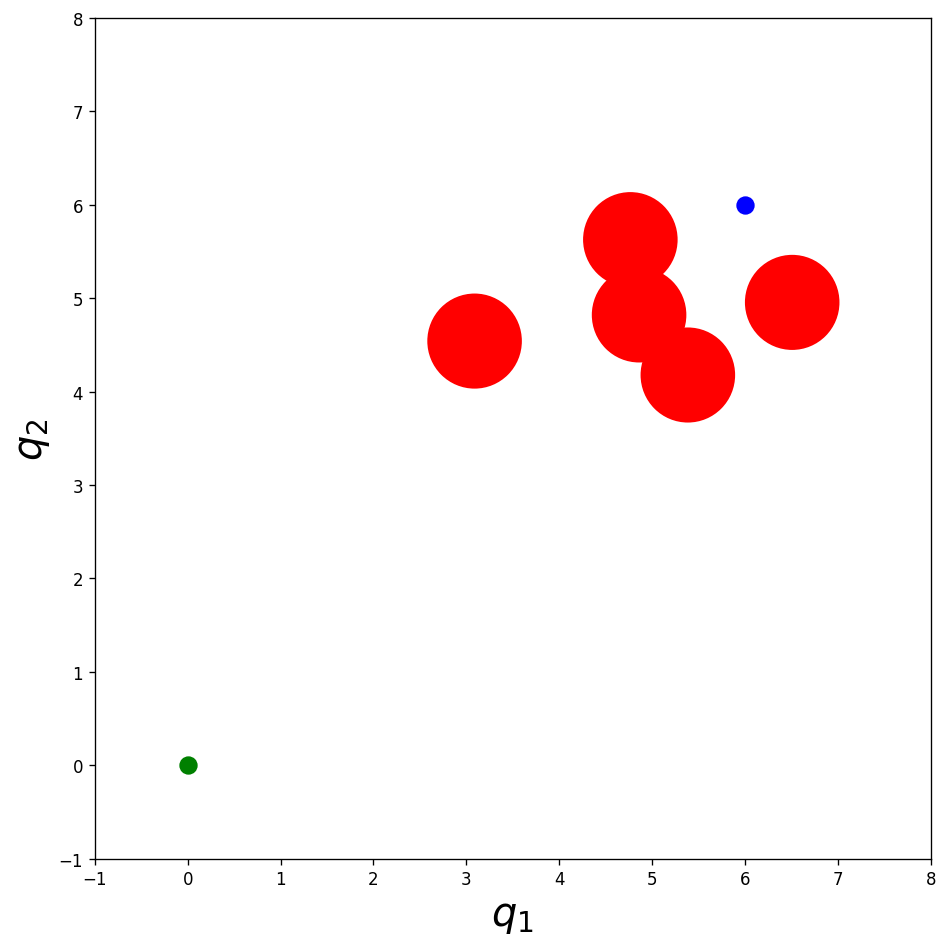

In [47]:
obs_list = []
for i in range(5):
    obs_list.append(np.random.uniform(3, 7, size=2))
task.set_obstacle_list(obs_list)

task.q_0 = np.array([6.0, 6.0])
task.q_d = np.array([0.0, 0.0])
task.dq_0 = np.array([0.0, 0.0])

task.plot_environment(None)

In [86]:
task.q_0 = np.array([5.5, 5.5])
T_lookahead = 4.0
task.T_lookahead = T_lookahead

num_basis = 3
mu_p_list, sigma_p_list, w_opt = run_opt(1000, num_basis)

mu_p = mu_p_list[-1]
sigma_p = sigma_p_list[-1]

q_list = np.zeros((N, len(task.t_cost_array), task.ndof))
p_list = np.random.multivariate_normal(mu_p, sigma_p, N)
for n in range(N):
    w = np.concatenate((task.q_0, p_list[n], task.q_d, task.dq_0, np.zeros(task.ndof)))
    q_list[n] = (task.Phi @ w).reshape(len(task.t_cost_array), task.ndof)
    
dq_list = (task.dPhi @ w_opt).reshape(len(task.t_cost_array), task.ndof)
ddq_list = (task.ddPhi @ w_opt).reshape(len(task.t_cost_array), task.ndof)

q_via = mu_p.reshape(int(len(mu_p)/task.ndof), task.ndof)

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=228262, Tue Apr  5 16:42:03 2022)
Elapsed time:  3.7257370948791504  [s]


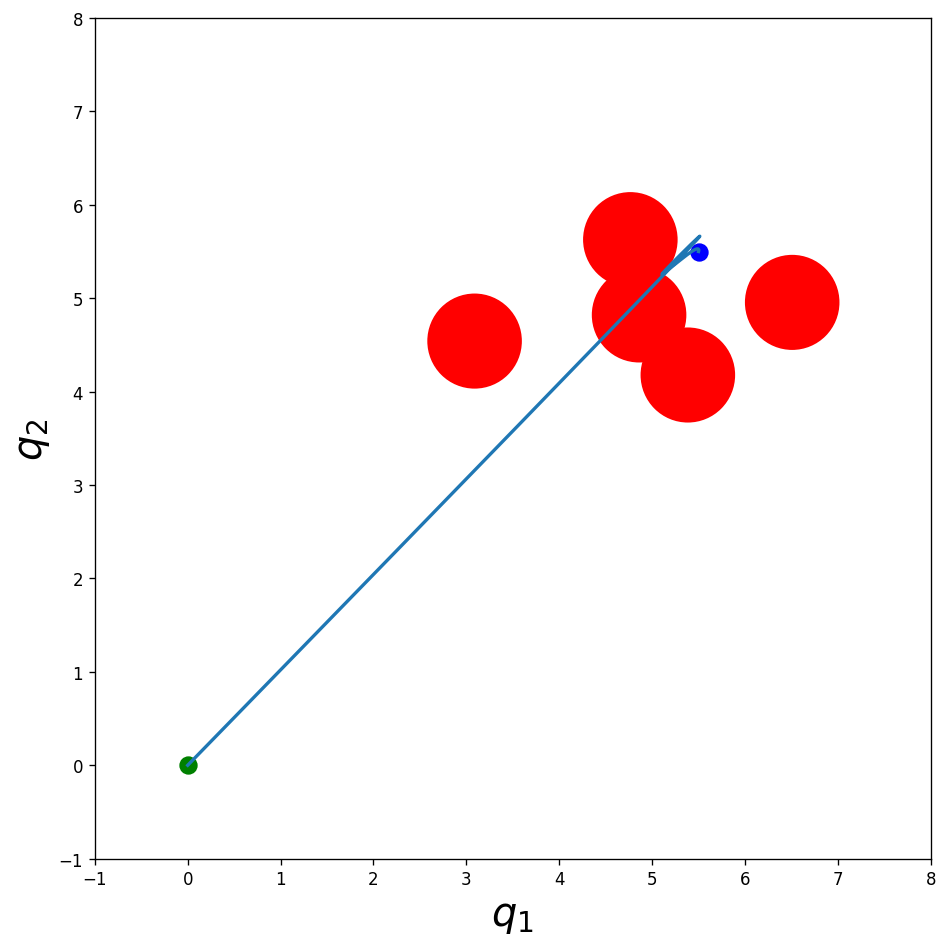

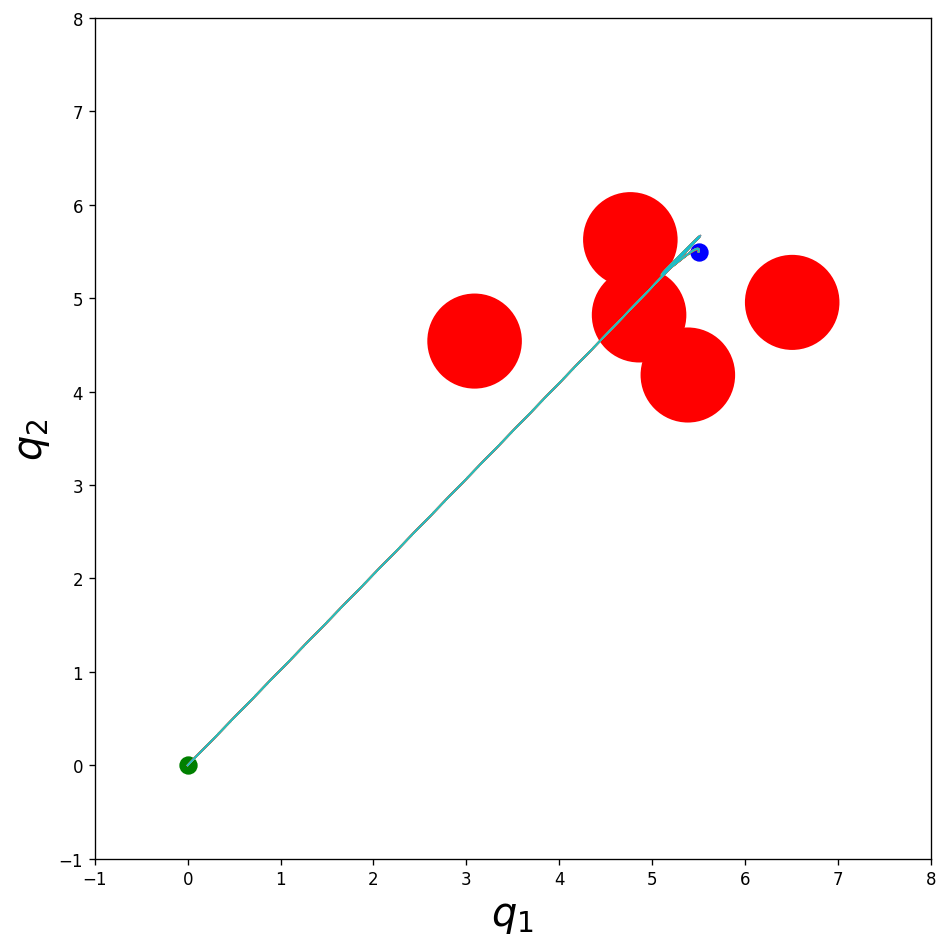

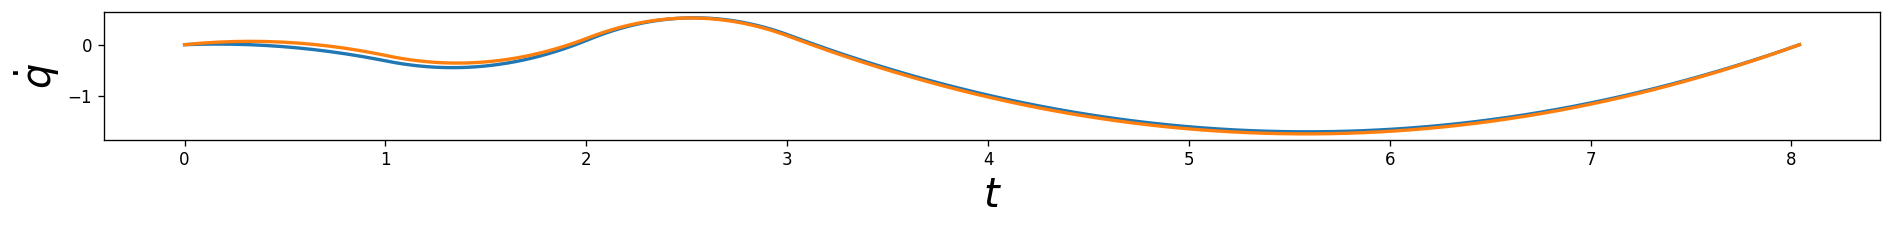

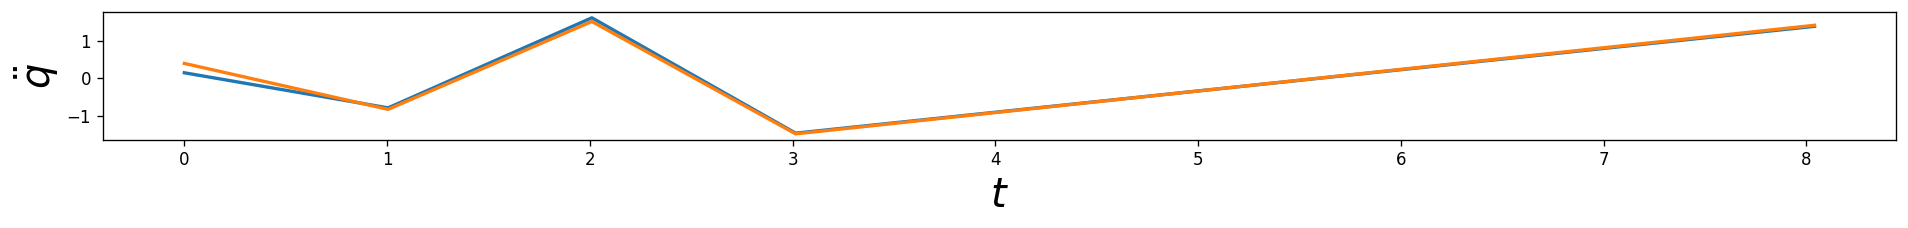

In [87]:
task.plot_environment((task.Phi @ w_opt).reshape(len(task.t_cost_array), task.ndof))
task.plot_environment(q_list)
#task.plot_q(q_list)
task.plot_dq(dq_list)
task.plot_ddq(ddq_list)

task.set_obstacle_list([])
for i in range(len(dyn_obs_list)):
    x_obs_start = dyn_obs_list[i][0]
    x_obs_end = x_obs_start + T_dur * obs_speed * np.array([np.cos(dir_obs_list[i]*np.pi/8), np.sin(dir_obs_list[i]*np.pi/8)])
    dyn_obs_list[i] = np.array([np.linspace(x_obs_start[0], x_obs_end[0], len(q_list)), np.linspace(x_obs_start[1], x_obs_end[1], len(q_list))]).T
task.set_dyn_obstacle_list(dyn_obs_list)
task.T = T_dur
task.save_animation(q_list)

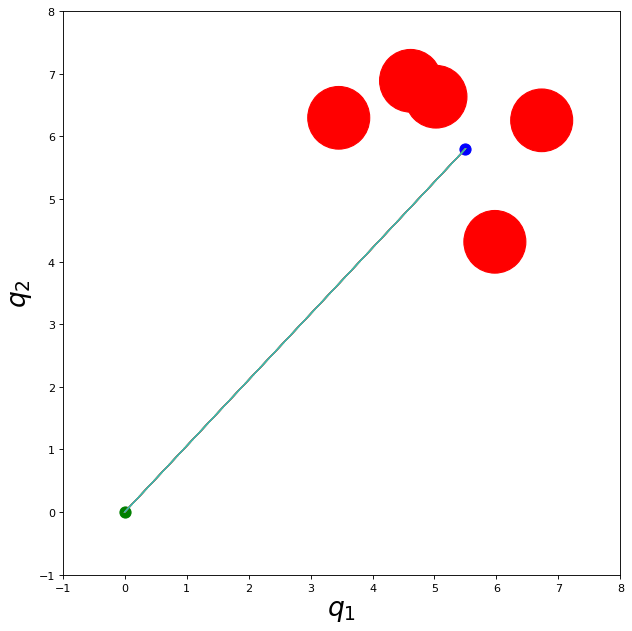

In [15]:
# fig, ax = plt.subplots(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

# fps = 20
# dt_ani = 1./fps

# plt.xlabel(r'$q_1$', fontsize=task.fontsize_)
# plt.ylabel(r'$q_2$', fontsize=task.fontsize_)

# plot = ax.plot(q_list[:,:,0].T, q_list[:,:,1].T, lw=1)
# #plt.scatter(q_via[:,0], q_via[:,1])
# plt.scatter(task.q_0[0], task.q_0[1], s=100, color='b')
# plt.scatter(task.q_d[0], task.q_d[1], s=100, color='g')

# ax = plt.gca()
# ax.set_xlim([-1,8])
# ax.set_ylim([-1,8])
# obs_list = []
# for s in task.x_obs:
#     obs_list.append(plt.Circle((s[0], s[1]), task.r_obs, color='r'))
#     ax.add_patch(obs_list[-1])

# plt.tight_layout()

# def animate(i):
#     p_list = np.random.multivariate_normal(mu_p_list[i], sigma_p_list[i], N)
#     for n in range(N):
#         w = np.concatenate((task.q_0, p_list[n], task.q_d, task.dq_0, np.zeros(task.ndof)))
#         q_ = (task.Phi @ w).reshape(len(task.t_cost_array), task.ndof)
#         plot[n].set_xdata(q_[:,0])
#         plot[n].set_ydata(q_[:,1])
#     return plot[0],

# ani = animation.FuncAnimation(
# fig, animate, interval=dt_ani*1e3, blit=True, frames=len(mu_p_list), repeat=False)

# video_name = r"/home/julius/Documents/python/pac/traj_opt/media/STORM_convergence.mp4" 
# writervideo = animation.FFMpegWriter(fps=fps)
# ani.save(video_name, writer=writervideo)